In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def normalizer(x):
    '''
    input : 
        x 1D array
    return :
        1D array normalized for the sum of it to be 1
    '''
    temp = np.zeros(len(x))
    sum = 0
    for i in range(len(x)):
        sum += x[i]
    for i in range(len(x)):
        temp[i]=x[i]/sum
    return temp

def random_row_generator(x, uniform = False):
    '''
    input :
        x = int
        uniform = boolean default to be false
    
    return :
        unifrom = True
            return x length unifrom 1D array
        uniform = False
            return x length random 1D array 
    
    '''
    if uniform:
         return normalizer(np.ones(x))
    return normalizer(np.random.rand(x))

def random_sequence_generator(states, length):
    '''
    input : 
        states = int
        length = int
    return :
        return 1D array 
                which length is length
                    each value is one of the integer between 0 ~ (states - 1)
    
    '''
    return np.random.randint(states, size = length)


In [3]:
def print_setting(setting):
    '''
    print every variabels in Hidden Markov Model defined by setting
    '''
    print("Initial probability")
    print(setting['initial'])
    print("Transition matrix probability")
    print(setting['transition'])
    print("Observation matrix probability")
    print(setting['observation'])

# Initial problem setting

In [4]:
def HMM_initalization(observed_states, hidden_states, uniform =False):
    '''
    
    input :
        observed states = int
        hidden_states = int
        uniform = boolean default to be false
    output :
        initialize every variables in HMM
        the number of hidden_states = hidden_states
        the number of observed states = observed_states
        if unifrom is True
            return uniformly initailized probabilities
        if uniform is False 
            return randomly initialized probabilities
            
    '''
    
    initial = random_row_generator(hidden_states,uniform)
    transition = []
    observation = []
    for i in range(hidden_states):
        transition.append(random_row_generator(hidden_states,uniform))
    for i in range(hidden_states):
        observation.append(random_row_generator(observed_states,uniform))
    transition = np.array(transition)
    observation = np.array(observation)
    return {'initial' : initial, 'transition' : transition, 'observation' : observation}

In [5]:
hstates = 3
ostates = 4
setting = HMM_initalization(ostates, hstates)
print_setting(setting)

Initial probability
[ 0.31130777  0.31474922  0.37394301]
Transition matrix probability
[[ 0.43275538  0.56378792  0.0034567 ]
 [ 0.39418119  0.13049435  0.47532446]
 [ 0.3305761   0.55212438  0.11729952]]
Observation matrix probability
[[ 0.24353653  0.37573434  0.09580714  0.284922  ]
 [ 0.25403262  0.1745957   0.24482044  0.32655123]
 [ 0.27007142  0.02674488  0.39098428  0.31219942]]


# Evaluation Problem
    Forward Recursion
    Backwrd Recursion

    Forward_k[i] = P(o1o2...ok, qk=si)  
    Backward_k[i] = P(o(k+1)o(k+2)...oL|qk=si)

In [6]:
observed_length = 10

In [7]:
def encoding_problem(observed_sequence, initial, transition, observation):
    '''
    input :
        observed_sequence : 1D array 
                            each value(0 ~ observed_states-1)
        initial : 1D array(hidden_states)
                    initial probability of hidden states
        transition : 2D array(hidden_states*hidden_states)
                    transition probability of hidden_state to hidden state
        observation : 2D array(hidden_states*observed_states)    
                    Observed probability of observed states for given hidden states
                
    return :
        forward recursion
        backward recursion
    '''
    hidden_states, observed_states = observation.shape
    length = len(observed_sequence)
    
    if hidden_states!=len(initial) or hidden_states!=transition.shape[0] or hidden_states!=transition.shape[1]: 
        raise SizeError('Wrong input')    
    
    for i in range(length):
        if observed_sequence[i]<observed_states:
            continue
        else:
            raise WrongInputError('Observed sequence wrong')

    forward = np.zeros((length,hidden_states))
    for j in range(hidden_states):
        forward[0][j] = initial[j]*observation[j][observed_sequence[0]]
    for i in range(1, length):
        for j in range(hidden_states):
            for k in range(hidden_states):
                forward[i][j] += forward[i-1][k]*transition[k][j]*observation[j][observed_sequence[i]]
                
    backward = np.zeros((length,hidden_states))
    for j in range(hidden_states):
        backward[length-1][j] = 1
    for i in range(1,length):
        for j in range(hidden_states):
            for k in range(hidden_states):
                backward[length-1-i][j] += transition[j][k]*observation[k][observed_sequence[length-i]]*backward[length-i][k]
    return {'forward' : forward, 'backward' : backward}
def probability(seq, initial, transition, observation):
    "Solve the evalution problem with results from forward recursion"
    return np.sum(encoding_problem(seq, initial, transition, observation)['forward'][observed_length-1])

In [8]:
sequence = random_sequence_generator(ostates,observed_length)

init = setting['initial']
transit = setting['transition']
observe = setting['observation']

result = encoding_problem(sequence, init, transit, observe)
forward = result['forward']
backward = result['backward']

observed_sequence_probability = 0
for i in range(hstates):
    observed_sequence_probability+=init[i]*backward[0][i]*observe[i][sequence[0]]
print("Observed_sequence")
print(sequence)
print("Observed_sequence_probability from forward recursion")
print(np.sum(forward[observed_length-1]))  
print("Observed_sequence_probability from backward recursion")
print(observed_sequence_probability)
print("Use the function")
print(probability(sequence, init,transit,observe))

Observed_sequence
[0 3 1 1 2 2 2 2 3 2]
Observed_sequence_probability from forward recursion
6.56088614559e-07
Observed_sequence_probability from backward recursion
6.56088614559e-07
Use the function
6.56088614559e-07


# Decoding problem
    Viterbi Algorithm

    viterbi_k[j]=max_(q1...q(k-1)){P(q1,q2,...,q(k_1),q_k=sj,o1o2...ok)}

In [9]:
def decoding_problem(observed_sequence, initial, transition, observation):
    '''
    input :
        observed_sequence : 1D array 
                            each value(0 ~ observed_states-1)
        initial : 1D array(hidden_states)
                    initial probability of hidden states
        transition : 2D array(hidden_states*hidden_states)
                    transition probability of hidden_state to hidden state
        observation : 2D array(hidden_states*observed_states)    
                    Observed probability of observed states for given hidden states
                
    return 
        the most probable hidden sequence
        and viterbi matrix
    '''
    
    hidden_states, observed_states = observation.shape
    length = len(observed_sequence)
    
    if hidden_states==len(initial) and hidden_states==transition.shape[0] and hidden_states==transition.shape[1]: 
        print("Hidden states : {}, observed states : {}".format(hidden_states, observed_states))
    else:
        raise SizeError('Wrong input')
    
    for i in range(length):
        if observed_sequence[i]<observed_states:
            continue
        else:
            raise WrongInputError('Observed sequence wrong')
    length = len(observed_sequence)
    
    back_tracking_table = np.zeros((length,hidden_states),dtype=np.int32)
    viterbi = np.zeros((length,hidden_states))
    for j in range(hidden_states):
        viterbi[0][j] = initial[j]*observation[j][observed_sequence[0]]
        back_tracking_table[0][j] = j
    for i in range(1, length):
        for j in range(hidden_states):
            temp = np.zeros(hidden_states)
            for k in range(hidden_states):
                temp[k] = viterbi[i-1][k]*transition[k][j]*observation[j][observed_sequence[i]] 
            back_tracking_table[i][j] = np.argmax(temp)
            viterbi[i][j] = np.max(temp)
    hidden_sequence = np.zeros(length, dtype=np.int32)
    hidden_sequence[length-1] = np.argmax(viterbi[length-1])
    for i in range(1,length):
        hidden_sequence[length-1-i] = back_tracking_table[length-i][hidden_sequence[length-i]]
    return {'viterbi' : viterbi, 'hidden_sequence' : hidden_sequence}

In [10]:
sequence = random_sequence_generator(ostates,observed_length)
print("Observed_sequence")
print(sequence)
result = decoding_problem(sequence, init, transit, observe)
print("Viterbi")
print(result['viterbi'])
print("Hidden Sequence")
print(result['hidden_sequence'])

Observed_sequence
[1 1 0 0 1 0 1 0 3 2]
Hidden states : 3, observed states : 4
Viterbi
[[  1.16969019e-01   5.49538609e-02   1.00010608e-02]
 [  1.90192859e-02   1.15138393e-02   6.98600696e-04]
 [  2.00447567e-03   2.72395205e-03   1.47804940e-03]
 [  2.61492638e-04   2.87082052e-04   3.49677947e-04]
 [  4.34330754e-05   3.37084449e-05   3.64952922e-06]
 [  4.57748748e-06   6.22050774e-06   4.32720532e-06]
 [  9.21303280e-07   4.50584743e-07   7.90781752e-08]
 [  9.70977576e-08   1.31949537e-07   5.78422618e-08]
 [  1.48193702e-08   1.78762448e-08   1.95807861e-08]
 [  6.75103026e-10   2.64676101e-09   3.32219981e-09]]
Hidden Sequence
[0 0 1 2 0 1 0 0 1 2]


# Learning problem

In [11]:
def random_choice(states, p):
    '''
    input : 
        states = int
        p = positive 1D array length(=states)
    return :
        select between 0 ~ (states-1) according to probability distribution p
    
    '''
    if states != len(p):
        raise WrongstatesError
    r = np.random.rand()*np.sum(p)
    for i in range(states):
        r-=p[i]
        if r<=0:
            return i

In [12]:
def observed_sequence_generator(length, initial, transition, observation):   
    '''
    input:
        length : length of seqs
        initial : 1D array(hidden_states)
                    initial probability of hidden states
        transition : 2D array(hidden_states*hidden_states)
                    transition probability of hidden_state to hidden state
        observation : 2D array(hidden_states*observed_states)    
                    Observed probability of observed states for given hidden states
    return : 
        Generate observed states with length(=length) from HMM
    '''  
    hidden_states, observed_states = observation.shape
    
    if hidden_states!=len(initial) or hidden_states!=transition.shape[0] or hidden_states!=transition.shape[1]: 
        raise SizeError('Wrong input')

    hidden_seq = np.zeros(length, dtype=np.int32)
    observed_seq = np.zeros(length, dtype =np.int32)
    
    hidden_seq[0] = random_choice(hidden_states, p=initial)

    for i in range(1, length):
        hidden_seq[i] = random_choice(hidden_states, p = transition[hidden_seq[i-1]])
    
    for i in range(length):
        observed_seq[i] = random_choice(observed_states, p= observation[hidden_seq[i]])
    return observed_seq

    gamma_k[i]=P(qk = si| o1o2...oL)
    epsilon_k[i,j]=P(qk = si, q(k+1)=sj | o1o2...oL)

In [13]:
def Expectation(observed_sequence, initial, transition, observation):
    '''
    input :
        observed_sequence : 1D array 
                            each value(0 ~ observed_states-1)
        initial : 1D array(hidden_states)
                    initial probability of hidden states
        transition : 2D array(hidden_states*hidden_states)
                    transition probability of hidden_state to hidden state
        observation : 2D array(hidden_states*observed_states)    
                    Observed probability of observed states for given hidden states
                
    return :
        calculate the expectation values 
        gamma, and epsilon
        gamma_k[i]=P(qk = si| o1o2...oL)
        epsilon_k[i,j]=P(qk = si, q(k+1)=sj | o1o2...oL)
    '''
    
    result = encoding_problem(observed_sequence, initial, transition, observation)
    forward = result['forward']
    backward = result['backward']

    hidden_states, observed_states = observation.shape
    length = len(observed_sequence)

    gamma = np.zeros((length, hidden_states))
    epsilon = np.zeros((length-1, hidden_states, hidden_states))
    
    for i in range(length):
        temp_sum = 0
        for j in range(hidden_states):
            temp_sum += forward[i][j]*backward[i][j]
        for j in range(hidden_states):
            gamma[i][j] = forward[i][j]*backward[i][j]/temp_sum
    
    for i in range(length-1):
        temp_sum = 0
        for j in range(hidden_states):
            for k in range(hidden_states):
                temp_sum += forward[i][j]*backward[i+1][k]*transition[j][k]*observation[k][observed_sequence[i+1]]
        for j in range(hidden_states):
            for k in range(hidden_states):
                epsilon[i][j][k] = forward[i][j]*backward[i+1][k]*transition[j][k]*observation[k][observed_sequence[i+1]]/temp_sum
    return {'gamma' : gamma, 'epsilon' : epsilon}

In [14]:
def Maximization(observed_sequences, gamma, epsilon, observed_states, hidden_states):
    '''
    input :
        observed_sequences : 2D array(number_of_sequences * length)
                            each value(0 ~ observed_states-1)
        gamma : 3D array(number_of_sequences*length*hidden_states)
        epsilon : 4D array(number_of_sequences*length*hidden_states*hidden_states)
                
    return :
        calculate the paramaters in HMM from 
        gamma, and epsilon which maximizes the probability of observed sequences
    '''
    
    initial = np.zeros(hidden_states)
    transition = np.zeros((hidden_states,hidden_states))
    observation = np.zeros((hidden_states, observed_states))
    data_size, length = observed_sequences.shape
    
    for i in range(hidden_states):
        for d in range(data_size):
            initial[i] += gamma[d][0][i]
        initial[i]/=data_size
    
    for i in range(hidden_states):
        for j in range(hidden_states):
            temp1 = 0
            temp2 = 0
            for d in range(data_size):
                for l in range(length-1):
                    temp1 += epsilon[d][l][i][j]
                    temp2 += gamma[d][l][i]
            transition[i][j] = temp1/temp2
    
    for i in range(hidden_states):
        for j in range(observed_states):
            temp1 = 0
            temp2 = 0
            for d in range(data_size):
                for l in range(length):
                    if observed_sequences[d][l]==j:
                        temp1+=gamma[d][l][i]
                    temp2+=gamma[d][l][i]
            observation[i][j] = temp1/temp2
    return {'initial' : initial, 'transition' : transition, 'observation' : observation}

# Make the generative model with HMM and generate observed sequences

In [15]:
hstates = 3
ostates = 4
observed_length = 100
observed_num = 1000
answer_setting = HMM_initalization(ostates, hstates)
print_setting(answer_setting)

Initial probability
[ 0.26119164  0.37397762  0.36483074]
Transition matrix probability
[[ 0.3718124   0.35939068  0.26879692]
 [ 0.33257082  0.0773155   0.59011369]
 [ 0.37262171  0.28665564  0.34072265]]
Observation matrix probability
[[ 0.16580992  0.21851125  0.20696024  0.40871858]
 [ 0.1961674   0.30955819  0.20057819  0.29369623]
 [ 0.33237514  0.15470868  0.02176087  0.49115531]]


In [16]:
observed_storage = []
for i in range(observed_num):
    observed_storage.append(observed_sequence_generator(observed_length, answer_setting['initial']
                                ,answer_setting['transition']
                                ,answer_setting['observation']))

    
    observed_storage = np.array(observed_storage)
print(observed_storage.shape)

#print_setting(answer_setting)
#print(observed_storage)

(1000, 100)


Probability of answer : -130921.96540628369
Answer
Initial probability
[ 0.26119164  0.37397762  0.36483074]
Transition matrix probability
[[ 0.3718124   0.35939068  0.26879692]
 [ 0.33257082  0.0773155   0.59011369]
 [ 0.37262171  0.28665564  0.34072265]]
Observation matrix probability
[[ 0.16580992  0.21851125  0.20696024  0.40871858]
 [ 0.1961674   0.30955819  0.20057819  0.29369623]
 [ 0.33237514  0.15470868  0.02176087  0.49115531]]
Initial
Initial probability
[ 0.10704036  0.41842381  0.47453584]
Transition matrix probability
[[ 0.72875774  0.17387861  0.09736366]
 [ 0.34764238  0.36971816  0.28263947]
 [ 0.34251285  0.28868169  0.36880545]]
Observation matrix probability
[[ 0.18780172  0.28711384  0.42938068  0.09570376]
 [ 0.59467755  0.36361026  0.00165983  0.04005236]
 [ 0.1028728   0.10277863  0.33212878  0.46221979]]
Initial probability
[ 0.89051465  0.03623498  0.07325037]
Transition matrix probability
[[ 0.5402284   0.25887455  0.20089706]
 [ 0.21148015  0.28909251  0.499

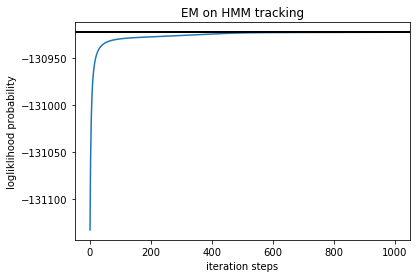

In [18]:
answer_probability = 0
for dataset in range(len(observed_storage)):
    answer_probability += math.log(probability(observed_storage[dataset]
                            ,answer_setting['initial']
                            ,answer_setting['transition']
                            ,answer_setting['observation']))

print("Probability of answer : {}".format(answer_probability))
print("Answer")
print_setting(answer_setting)

print("Initial")      
Learning_setting = HMM_initalization(ostates, hstates)
print_setting(Learning_setting)


iteration = 1000
Learn_probability = np.zeros(iteration)
for iter in range(iteration):
    gamma_set = []
    epsilon_set = []
    for dataset in range(len(observed_storage)):
        temp = Expectation(observed_storage[dataset]
                            ,Learning_setting['initial']
                            ,Learning_setting['transition']
                            ,Learning_setting['observation'])
        gamma_set.append(temp['gamma'])
        epsilon_set.append(temp['epsilon'])
    gamma_set = np.array(gamma_set)
    epsilon_set = np.array(epsilon_set)
    Learning_setting = Maximization(observed_storage, gamma_set, epsilon_set, ostates, hstates)
    
    for dataset in range(len(observed_storage)):
        Learn_probability[iter] += math.log(probability(observed_storage[dataset]
                                        ,Learning_setting['initial']
                                        ,Learning_setting['transition']
                                        ,Learning_setting['observation']))
print("After training")
print_setting(Learning_setting)

print("Learning process outline")
plt.plot(Learn_probability)
plt.axhline(y=answer_probability, xmin=0, xmax=iteration, linewidth=2, color = 'k')
plt.title("EM on HMM tracking")
plt.ylabel("logliklihood probability")
plt.xlabel("iteration steps")
plt.show()